# Treći domaći zadatak iz predmeta Digitalna obrada slike

## Danica Bandović 2018/0018

#### Zadatak 1

Ovaj zadatak sastoji se iz više celina. Za ulazne slike koriste se slike analognih satova, i potrebno je izvršiti detekciju ivica Canny-jevim algoritmom, zatim naći prave linije koje se nalaze na određenom pravcu, što će nam pomoći u nalaženju kazaljki na slici sata i na kraju određivanju vremena koje kazaljke na satu pokazuju. 

In [1]:
#učitavanje potrebnih modula i funkcija
import scipy
import matplotlib.pyplot as plt
import skimage
from skimage import *
from skimage.color import *
from skimage.exposure import *
from skimage.filters import *
from skimage import io
from scipy import ndimage
import os

import numpy as np

## a) Funkcija canny_edge_detection

U ovom delu zadatka implementiran je algoritam za detekciju ivica koji se sastoji od više koraka. Ivični pikseli su pikseli u čijem lokalnom susedstvu postoji nagla promena intenziteta, dok je ivica skup povezanih ivičnih piksela. Prvi korak u detekciji jeste niskofrekventno filtriranje. Ono služi da potisne šum sa slike, pošto šum iako je mali i ne vidi se golim okom, on značajno utiče na prvi izvod, a naročito na drugi izvod koji i sa malim šumom postaje praktično neupotrebljiv. Niskofrekventno filtriranje će zamutiti sliku malo, sa tim će ublažiti promene intenziteta na ivicama, ali ako je ono dovoljno veliko, moći će da se detektuje. Takođe možemo niskofrekventnim filtriranjem potisnuti i neke manje ivice koje ne želimo da budu detektovane. Nakon NF filtriranja primenjuje se operator koji će tamo gde postoji promena intenziteta, dati neke vrednosti i reći nam koliko je značajan intenzitet. Određivanje horizontalnih i vertikalnih gradijenata izvršena je Sobelovim operatorom, i dalji koraci urađeni su kao po tekstu zadatka: određeni su magnituda i ugao, izvršena kvantizacija gradijenta na jedan od 4 pravaca, potisnuti su ne-maksimalni pikseli i na osnovu mapa jakih i slabih piksela dodavani slabi pikseli u ivice kako bi se konačne ivice dobile. U nastavku sledi kod funkcije kao i objasnjenja pojedinih koraka u komentarima.

In [2]:
def sobel_gradient(image):
    """
    Funkcija koja nalazi gradijente Sobelovim operatorom.
    
    Ulazni parametri:
    image(ndarray): ulazna slika za koju treba da nadjemo gradijente
    
    Izlazni parametri:
    Gx(ndarray): vertikalne ivice
    Gy(ndarray): horizontalne ivice
    mag(ndarray): magnituda piksela
    angle(ndarray): ugao gradijenta
    """
    Hx = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    # transponovanje matrice
    Hy = np.transpose(Hx)

    # izracunavanje vertikalnog i horizontalnog gradijenta slike
    Gx = ndimage.convolve(image, Hx, mode='nearest')
    Gy = ndimage.convolve(image, Hy, mode='nearest')

    
    #figure, ax=plt.subplots(nrows=2, ncols=2, figsize=(20,16), dpi=80)

    #ax[0,0].imshow(image, cmap='gray', vmin=0, vmax=1), ax[0,0].set_title('Originalna slika'), ax[0,0].axis('off')
    #ax[1,0].imshow(image, cmap='gray', vmin=0, vmax=1), ax[1,0].set_title('Originalna slika'), ax[1,0].axis('off')
    #ax[0,1].imshow(Gx, cmap='gray', vmin=np.amin(Gx), vmax=np.amax(Gx)), ax[0,1].set_title('Horizontalne ivice - vertikalni gradijent)'), ax[0,1].axis('off')
    #ax[1,1].imshow(Gy, cmap='gray', vmin=np.amin(Gy), vmax=np.amax(Gy)), ax[1,1].set_title('Vertikalne ivice - horizontalni gradijent'), ax[1,1].axis('off')
    #plt.tight_layout()
    #plt.show()
    
    
    # magnituda gradijenta
    mag = np.sqrt(np.square(Gx) + np.square(Gy))
    #mag = np.abs(Gx) + np.abs(Gy);
    # pomocna promenljiva kako ne bi izlazio warning za deljenje sa nulom
    Gx_fix = np.copy(Gx)
    Gx_fix[Gx_fix == 0] = 1
    angle = np.arctan(np.divide(Gy, Gx_fix))
    angle[(Gx == 0) & (Gy > 0)] = np.pi/2
    angle[(Gx == 0) & (Gy < 0)] = -np.pi/2
    angle[(Gx == 0) & (Gy == 0)] = 0
    return (Gx, Gy, mag, angle)

In [ ]:
image = io.imread(f'../sekvence/clocks/clock2.png')
image = skimage.img_as_float(image)
ul_slika = rgb2gray(rgba2rgb(image))
img_gauss = skimage.filters.gaussian(ul_slika,0.2, mode='nearest', truncate=3)
(Gx_g, Gy_g, mag_g, angle_g) = sobel_gradient(img_gauss)

Kod prelaza sa svetlijeg na tamniji piksel na slici, vrednost gradijenta će biti negativan, pa će na slici to biti prikazano tamnim vrednostima, dok je kod prelaska sa tamne površine na svetlu vrednost gradijenta pozitivna i to će biti prikazano svetlijim pikselima na slici horizontalnih i vertikalnih ivica.

In [3]:
def canny_edge_detection(img_in, sigma, treshold_low, treshold_high):
    # niskofrekventno filtriranje
    # truncate*sigma=radius, a radius=3*sigma
    img_gauss = skimage.filters.gaussian(img_in, sigma, mode='nearest', truncate=3)
    # izdvajanje gradijenta sobelovim operatorom
    (Gx_g, Gy_g, mag_g, angle_g) = sobel_gradient(img_gauss)

    # potiskivanje ne lokalnih maksimuma
    M = np.zeros(np.shape(img_in))
    angle = angle_g*180/np.pi
   
    #kvantizacija gradijenta na jedan od pravaca
    for i in range(1, np.shape(img_in)[0]-1):
        for j in range(1, np.shape(img_in)[1]-1):
            #određivanje suseda na osnovu gradijenta piksela
            if angle[i, j] >= -22.5 and angle[i, j] < 22.5:
                # susedstvo koje posmatramo ako je ugao nula
                a = mag_g[i, j+1]
                b = mag_g[i, j-1]
            elif angle[i, j] >= 22.5 and angle[i, j] < 67.5:
                # susedstvo koje posmatramo ako je ugao 45 stepeni
                a = mag_g[i+1, j-1]
                b = mag_g[i-1, j+1]
            elif angle[i, j] >= 67.5 or angle[i, j] < -67.5:
                # ugao je 90 stepeni
                a = mag_g[i+1, j]
                b = mag_g[i-1, j]
            else:
                # ugao je -45 stepeni
                a = mag_g[i-1, j-1]
                b = mag_g[i+1, j+1]
            if mag_g[i, j] >= a and mag_g[i, j] >= b:
                #ako je trenutni piksel veći od suseda znači da je lokalni maksimum
                #te njega ne potiskujemo
                M[i, j] = mag_g[i, j]


    # Maska ivica dobijena poredjenjem sa pragom
    tl = np.max(mag_g)*treshold_low
    th = np.max(mag_g)*treshold_high
    maska = np.zeros(np.shape(mag_g))
    i, j = np.where(mag_g >= th)
    
    #jakim ivicama dodeljuje se vrednost 255, a slabim 125
    #ostali elementi imaju vrednost 0
    maska[i, j] = 255
    i, j = np.where((mag_g >= tl) & (mag_g < th))
    maska[i, j] = 125

    # ukljucivanje slabih ivica
    #više prolazaka kroz matricu sve dok se promena matrice nije nula
    
    #koliko ima jakih piksela
    sum = len(maska[maska == 255])   
    #prolazak kroz matricu i ubacivanje određenih slabih piksela u jake
    for i in range(1, np.shape(img_in)[0]-1):
        for j in range(1, np.shape(img_in)[1]-1):
            if maska[i, j] == 125:
                maska[i, j] = 255*(maska[i-1, j-1] == 255 or maska[i-1, j] == 255 or maska[i-1, j+1] == 255 or maska[i, j-1]
                                   == 255 or maska[i, j+1] == 255 or maska[i+1, j-1] == 255 or maska[i+1, j] == 255 or maska[i+1, j+1] == 255)
    pret = sum
    sum = len(maska[maska == 255])
    while (pret != sum):
        for i in range(1, np.shape(img_in)[0]-1):
            for j in range(1, np.shape(img_in)[1]-1):
                if maska[i, j] == 125:
                    maska[i, j] = 255*(maska[i-1, j-1] == 255 or maska[i-1, j] == 255 or maska[i-1, j+1] == 255 or maska[i, j-1]
                                       == 255 or maska[i, j+1] == 255 or maska[i+1, j-1] == 255 or maska[i+1, j] == 255 or maska[i+1, j+1] == 255)
        pret = sum
        sum = len(maska[maska == 255])
    
    
    maska[maska<255]=0;
    
    return maska


Kroz dva primera prikazano je kako određeni parametri utiču na rezultat funkcije:

In [ ]:
#testiranje funkcije
i=2;
image = io.imread(f'../sekvence/clocks/clock{i}.png')
image = skimage.img_as_float(image)
ul_slika = rgb2gray(rgba2rgb(image))
        
#detekcija ivica
iout = canny_edge_detection(ul_slika, 0.2, 0.09, 0.2)
figure,axes = plt.subplots(nrows=1,ncols=4,figsize=(22,15),dpi=80)
axes[0].imshow(ul_slika,cmap='gray',vmin=0,vmax=1);axes[0].set_title('Ulazna slika, siva');axes[0].axis('off');
axes[1].imshow(iout,cmap='gray');axes[1].set_title('sigma=0.2,tl=0.09,th=0.2');axes[1].axis('off');
iout = canny_edge_detection(ul_slika, 0.2, 0.2, 0.5)
axes[2].imshow(iout,cmap='gray');axes[2].set_title('sigma=0.2,tl=0.2,th=0.5');axes[2].axis('off');
iout = canny_edge_detection(ul_slika, 0.2, 0.5, 0.8)
axes[3].imshow(iout,cmap='gray');axes[3].set_title('sigma=0.2,tl=0.5,th=0.8');axes[3].axis('off');
plt.show()

i=9;
image = io.imread(f'../sekvence/clocks/clock{i}.png')
image = skimage.img_as_float(image)
ul_slika = image
        
#detekcija ivica
iout = canny_edge_detection(ul_slika, 0.2, 0.09, 0.2)
figure,axes = plt.subplots(nrows=1,ncols=4,figsize=(22,15),dpi=80)
axes[0].imshow(ul_slika,cmap='gray',vmin=0,vmax=1);axes[0].set_title('Ulazna slika, siva');axes[0].axis('off');
axes[1].imshow(iout,cmap='gray');axes[1].set_title('sigma=0.2,tl=0.09,th=0.2');axes[1].axis('off');
iout = canny_edge_detection(ul_slika, 0.2, 0.2, 0.5)
axes[2].imshow(iout,cmap='gray');axes[2].set_title('sigma=0.2,tl=0.2,th=0.5');axes[2].axis('off');
iout = canny_edge_detection(ul_slika, 0.2, 0.5, 0.8)
axes[3].imshow(iout,cmap='gray');axes[3].set_title('sigma=0.2,tl=0.5,th=0.8');axes[3].axis('off');
plt.show()

Što su gornji i donji prag veći to će manje piksela biti izdvojeno kao ivični pikseli, što se iz gornjih primera može i uočiti. Za veće pragove linije koje predstavljaju ivice su tanje nego ako su pragovi manji, a naročito na ovo utiče donji prag. Osim što su tanje ivice, može se desiti da budu i prekidne. U primeru drugog sata uočava se da nekada nije loše da pragovi budu veći jer su dve ivice (okvir slike na primer) veoma blizu te se ivični pikseli dveju različitih ivica maltene spoje na nekim mestima, te se i ne primećuje da postoje dve ivice jedna blizu druge.
Dalje proveravamo kako uticaj niskofrekventnog filtriranja, odnosno parametra sigma utiče na detekciju:

255.0
0.0
255.0
0.0
255.0
0.0


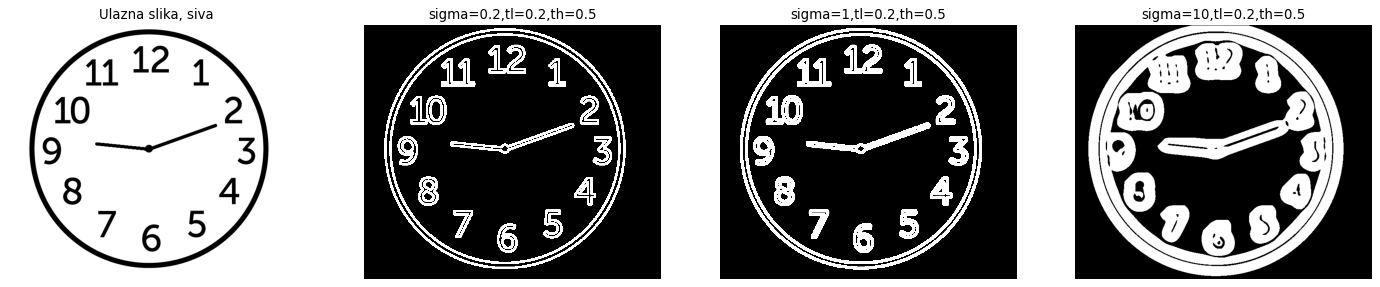

In [8]:
#testiranje funkcije
i=2;
image = io.imread(f'../sekvence/clocks/clock{i}.png')
image = skimage.img_as_float(image)
ul_slika = rgb2gray(rgba2rgb(image))
        
#detekcija ivica
iout = canny_edge_detection(ul_slika, 0.2, 0.2, 0.5)
figure,axes = plt.subplots(nrows=1,ncols=4,figsize=(22,15),dpi=80)
axes[0].imshow(ul_slika,cmap='gray',vmin=0,vmax=1);axes[0].set_title('Ulazna slika, siva');axes[0].axis('off');
axes[1].imshow(iout,cmap='gray');axes[1].set_title('sigma=0.2,tl=0.2,th=0.5');axes[1].axis('off');


iout = canny_edge_detection(ul_slika, 1, 0.2, 0.5)

axes[2].imshow(iout,cmap='gray');axes[2].set_title('sigma=1,tl=0.2,th=0.5');axes[2].axis('off');
iout = canny_edge_detection(ul_slika, 10, 0.2, 0.5)

axes[3].imshow(iout,cmap='gray',);axes[3].set_title('sigma=10,tl=0.2,th=0.5');axes[3].axis('off');
plt.show()


Iako je dobro da postoji niskofrekventno filtriranje, parametar sigma ne treba da bude veliki, jer kao što se vidi sa gornjih slika, ako je sigma veliko dolazi do razlivanja ivica odnosno zamućivanja, što nam svakako nije cilj. Već za sigma veće od 1, ivice postaju previše debele.

## b) Izdvajanje duži na zadatom pravcu

Pomoćne funkcije:

In [ ]:
def valid(x, y, img):
    """
    Funkcija koja proverava da li su koordinate
    x i y za sliku img, izasli van okvira
    slike, odnosno vraca True ako su koordinate
    validne, False ako nisu.    
    """
    if x < 0 or x >= len(img) or y < 0 or y >= len(img[0]):
        return False
    return True


def find_white(img_edges, x, y, delta):
    """
    Funkcija koja proverava da li se u susedstvu 
    radijusa delta, piksela sa koordinatama x,y,
    nalazi neki piksel koji je ivicni.
    """
    for dx in range(int(-delta/2), int(delta/2+1)):
        for dy in range(int(-delta/2), int(delta/2+1)):
            if not valid(x+dx, y+dy, img_edges):
                continue
            if(img_edges[x+dx][y+dy] != 0):
                return True
    return False


def distance_between(first, last):
    """
    Racunanje razdaljine izmedju dva piksela.
    """
    return np.sqrt((first[0]-last[0])**2 + (first[1]-last[1])**2)

Na osnovu theta i rho odredi se prvo jednačina prave y=kx+n, gde je k=tan(alfa), n je vrednost koja odgovara preseku prave sa y-osom a alfa ugao koji prava zaklapa sa pozitivnim delom x-ose. Nakon što se odredi jednačina prave, ideja je da se za svaku vrednost x koordinate izračuna vrednost y koordinate i vidi da li je piksel na slici koji je u radijusu (tolerancy) tačke u prostoru (x,y) piksel koji odgovara ivičnom pikselu. Pravimo duž sve dok imamo ivični piksel u radijusu okoline i dok je broj uzastopnih crnih piksela, tj. veličina prekida, manja od max_gaps vrednosti. U suprotnom je kraj trenutne duži koju smo našli, i nju ubacujemo u niz samo ako je dovoljno dugačka da bismo je smatrali duži (njena dužina je veća od min_size). U ovoj funkciji koristimo pomoćne funkcije čiji se kod nalazi iznad, a objašnjenje šta koja funkcija radi dato je u komentarima unutar koda. Sledi kod funkcije uz objašnjena koraka u komentarima:

In [ ]:
def get_line_segmentation(img_edges, line, min_size, max_gaps, tolerancy):
    """
    Funkcija koja na osnovu matrice izdvojenih
    ivica i pravca linije izdvaja sve duzi koje
    se nalaze na tom pravcu.
    
    Ulazni parametri:
    img_edges(ndarray): matrica izdvojenih ivica slike
    line(array): niz od dva elementa [theta,rho], kojim
    se zadaje pravac linije.
    min_size(int):minimalan broj piksela koji sadrzi 
    duz da bi mogla biti detektovana.
    max_gaps(int): maksimalne velicine prekida u pik-
    selima koje se mogu ignorisati pri detekciji duzi.
    tolerancy(int): radijus okoline u okviru koje se
    traze ivicni pikseli.
    
    Izlazni parametri: 
    line_segments: niz detektovanih duzi gde je
    svaka duz prikazana koordinatama pocetne i krajnje 
    tacke duzi.
    """
    
    #izdvajanje parametara theta i rho 
    theta, rho = line[0], line[1]
    
    #nalazenje jednacine prave odnosno pravca na kom trazimo duzi 
    alfa = 0
    n = 0
    x_alt = -1
    if theta > 0 and theta < np.pi/2:
        alfa = np.pi/2+theta
        n = rho/np.sin(theta)
    elif theta < 0 and theta > -np.pi/2:
        alfa = np.pi/2-np.abs(theta)
        # ovde sam n promenio samo ja msm
        n = rho/np.sin(np.abs(theta))
    elif theta > np.pi/2 and theta < np.pi:
        alfa = np.pi-theta
        n = rho/np.sin(np.pi-theta)
    elif theta == 0:
        n = 0
        alfa = np.pi/2
        x_alt = rho
    elif theta == np.pi/2:
        n = rho
        alfa = 0
    else:
        print("Nevalidna vrednost za theta")
        return -1

    pravac = []
    linija = []
    duz = 0
    gap = 0
    lastWhite = []
    firstBlack, lastBlack = [], []
    if (x_alt != -1):
        #ako je ugao 0, prava je x=rho, pri cemu onda menjamo y u celom opsegu
        x = rho
        for y in range(np.shape(img_edges)[1]):
            if find_white(img_edges, x, y, tolerancy):
                #U radijusu okoline nadjen je ivicni piksel
                if duz == 0:
                    #nije zapoceta duz tako da je ovaj piksel pocetni piksel potencijalne duzi
                    linija.append([x, y])
                    duz = 1
                    firstBlack, lastBlack = [], []
                lastWhite = [x, y]
            else:
                #nema ivice u okolini, doslo je do prekida duzi
                lastBlack = [x, y]
                if (firstBlack == []):
                    firstBlack = [x, y]
                #prekid racunamo kao razdaljinu od prvog do poslednjem crnog piksela, tako da nisu prekinuti nijednim belim
                gap = distance_between(firstBlack, lastBlack)                
                if gap > max_gaps:
                    #ako je prekid veci od max_gaps znaci da je zavrsena trenutna duz
                    if len(linija) > 0:
                        #racunanje duzine duzi
                        duz = distance_between(linija[0], lastWhite)
                    if duz >= min_size:
                        #ako je duzina duzi dovoljna da se smatra duzi, ubacujemo je u nadjenje duzi
                        linija.append(lastWhite)
                        #linija.append(duz)
                        pravac.append(linija)
                    gap = 0
                    duz = 0
                    linija = []
    else:
        #krecemo se po pravoj y=tan(alfa)*x+n
        for x in range(np.shape(img_edges)[0]):
            #racunanje y za trenutnu vrednost x
            y = int(x*np.tan(alfa)+n)
            if (y >= np.shape(img_edges)[1] or y < 0):
                continue
            
            if find_white(img_edges, x, y, tolerancy):
                #U radijusu okoline nadjen je ivicni piksel
                if duz == 0:
                    #nije zapoceta duz tako da je ovaj piksel pocetni piksel potencijalne duzi
                    linija.append([x, y])
                    duz = 1
                    firstBlack, lastBlack = [], []
                lastWhite = [x, y]
            else:
                #nema ivice u okolini, doslo je do prekida duzi
                lastBlack = [x, y]
                if (firstBlack == []):
                    firstBlack = [x, y]
                #prekid racunamo kao razdaljinu od prvog do poslednjem crnog piksela, tako da nisu prekinuti nijednim belim
                gap = distance_between(firstBlack, lastBlack)
                if gap > max_gaps:
                    #ako je prekid veci od max_gaps znaci da je zavrsena trenutna duz
                    if len(linija) > 0:
                        #racunanje duzine duzi
                        duz = distance_between(linija[0], lastWhite)
                    if duz >= min_size:
                        #ako je duzina duzi dovoljna da se smatra duzi, ubacujemo je u nadjenje duzi
                        linija.append(lastWhite)
                        #linija.append(duz)
                        pravac.append(linija)
                    duz = 0
                    linija = []

    line_segments = pravac;
    if len(pravac) > 0:
        return line_segments
        #return pravac[0]
    return []


Od parametara funkcije zavise rezultati. U primeru ispod prikazane su duži koje algoritam izdvaja ukoliko se zada mala minimalna dužina duži i veliki broj prekida u pikselima. Primećuje se da algoritam pronalazi i nešto što nije duž, ali je dozvoljeni prekid veliki pa je spojio piksele u duž (kod brojeva 9 i 3). Ako se smanji maksimalan dozvoljen prekid, za ovaj slučaj će algoritam izdvojiti samo ivicu na kazaljki, što je potrebno za narednu tačku zadatka.

In [ ]:
i=1;
image = io.imread(f'../sekvence/clocks/clock{i}.png')
image = skimage.img_as_float(image)
ul_slika = rgb2gray(rgba2rgb(image))
iout = canny_edge_detection(ul_slika, 0.2, 0.2, 0.4)
theta,rho=0,350
curr_linija = get_line_segmentation(iout, [0, 350], 30, 10, 3)
plt.figure()
plt.imshow(iout, cmap='gray')
for linija in curr_linija:
    y_values = [linija[0][0], linija[1][0]]
    x_values = [linija[0][1], linija[1][1]]
    plt.plot(x_values, y_values,'r')
    plt.axis("off")
plt.show()

In [ ]:
theta,rho=0,350
curr_linija = get_line_segmentation(iout, [0, 350], 30, 2, 3)
plt.figure()
plt.imshow(iout, cmap='gray')
for linija in curr_linija:
    y_values = [linija[0][0], linija[1][0]]
    x_values = [linija[0][1], linija[1][1]]
    plt.plot(x_values, y_values,'r')
    plt.axis("off")
plt.show()

Što se tiče radijusa okoline koja se posmatra, ona utiče na algoritam samo ako rho i theta ne znamo egzaktno, što i jeste pretpostavka, da približno tačno imamo rho i theta, te bez radijusa ne bi mogla da se pronađe duž na slici na zadatom pravcu čak i ukoliko je duž po pravcu pomerena za 1 piksel samo. Zato je dobro zadati određeni radijus, ali se proverom utvrđuje da je za ove slike satova dovoljno koristiti radijus 2 ili 3 piksela jer su rezultati dovoljno dobri.

## c) nalaženje sati, minuti i sekundi koje pokazuje sat

Ideja za pronalaženje sati i minuta leži u uglu theta kojim je zadata normala na pravac kazaljki za sate i minute. Da je neka duz ivica kazaljke možemo da znamo po tome što je duža od svih ostalih linija na tom pravcu i po tome što su i njeni  početak i kraj u određenom radijusu u odnosu na centar sata. Zbog toga su u algoritmu računate koordinate centra sata, kao i udaljenost kraja i početka nađenih duži od tog centra. Funkciju get_line_segments pozivamo ne samo za ono rho koje smo dobili iz Hafova transformacije, već i za neku okolinu, iz razloga što želimo da nađemo obe ivice kazaljke da bismo mogli da izračunamo debljinu kazaljke, što će pomoći kasnije kod izdvajanja kazaljke za sekunde. Debljina kazaljke računa se kao razlika odstojanja jedne i druge ivice od početno korišćenog rho. Lako možemo izračunati dužinu kazaljke na osnovu pocetnog i krajnjeg piksela ivice, i upoređivanjem dužina nađenih ivica, znaćemo da ivica manje dužine pripada kazaljki za sate, a veće dužine za minute. Zbog toga je bitno da upamtimo osim početka i kraja linije, debljinu i dužinu linije, ali i  ugao theta koji je korišćen za nalaženje ivice za taj pravac, jer nam je on potreban da kada nađemo koja je koja kazaljka, odredimo vreme. Sate i minute računamo na sličan način, formule se razlikuju u jednom broju. Ugao koji zaklapa kazaljka sa pravcem od 0 sati i 0 minuta, jednak je pi/2-theta. Sve se množi sa četvrtinom ukupnog broja sati ili minuti koji se nalaze na satu, dakle sa 15 za minute, odnosni sa 3 za sate, i pošto su sati i minuti celi brojevi, zaokružuje se na ceo broj. Ako se kazaljka nalazi na levoj polovini sata, na rezultat se dodaje 30 za minute, a 6 za sate, dok se u extract_time_bonus funkciji za sekunde dodaje 30. Zaokruživanje na ceo broj negde je uradjeno samo sa int, a za minute je prvo zaokruženo sa round iz razloga što se dešavalo da ako se samo sa int prebaci u celobrojnu vrednost da na jednom, dva sata, broj minuta bude pogrešan za jedan ili dva minuta. Sledi kod uz odgovarajuća objašnjenja u komentarima:

In [ ]:
def extract_time(ul_slika):
    """
    Funkcija koja vraća sate i minute koje 
    pokazuje sat na slici.
    
    Ulazni argumenti:
    slika: matrica slike sata 
    
    Izlazni argumenti:
    (sati,minuti): tuple od dve celobrojne
    vrednosti koje predstavlja vreme u 
    satima i minutima koje sat sa slike
    pokazuje.
    """
        
    #detekcija ivica
    #korišćene ulazne vrednosti parametara ne moraju biti ove koje
    #su korišćene ovde, ali treba uzeti u obzir pri odabiru parametara
    #diskusiju i rezultate za tačku pod a).
    iout = canny_edge_detection(ul_slika, 0.2, 0.2, 0.4)
    
    #nalazenje koordinata centra sata
    minY, maxY, minX, maxX = 1000000, 0, 1000000, 0
    for x, red in enumerate(iout):
        for y, piksel in enumerate(red):
            if piksel != 0:
                minY = min(minY, y)
                maxY = max(maxY, y)
                minX = min(minX, x)
                maxX = max(maxX, x)

    sredina_sataY = np.floor(minY + (maxY - minY)/2)
    sredina_sataX = np.floor(minX + (maxX - minX)/2)
    
    #nalazenje udaljenosti od pocetka, rho, i ugla theta
    a = (skimage.transform.hough_line(iout))
    b = skimage.transform.hough_line_peaks(*a, min_distance=100)
    _, angles, distances = b
    
    #uglovi se podesavaju da budu u odnosu na x osu
    angles = np.sign(angles)*np.pi/2-angles
    distances = [int(d) for d in distances]
    #print(f"D={distances}")
    #print(f"A={angles}")
    sve_linije = []
    for theta, rho in zip(angles, distances):         
        maxDuzina = 0
        linija = []
        #last i first koristimo kao neko dx za trazenje ivica kazaljke, te ce se debljina kazaljke racunati kao last-first
        first = -20
        last = -20
        for d in range(-15, 15):
            #debljina najdeblje kazaljke na satu ne prelazi 15 piksela 
            #tj ispod 15 piksela je, pa zato trazimo dve paralelne ivice 
            #koje su dovoljno debele da ih smatramo kazaljkama
            #nalazenje ivicnih linija kazaljki
            curr_linija = get_line_segmentation(iout, [theta, rho+d], 100, 2, 2)
            
            if curr_linija != []:
                #sledeci red je samo zbog daljeg koriscenja curr_linija promenljive(zbog dimenzija)
                #ali na satu se izdvaja uvek jedna ivica sa koriscenim parametrima 
                curr_linija=curr_linija[0]
                if first == -20:
                    first = d
                last = d
                tren_duzina = distance_between(curr_linija[0],curr_linija[1]);                
                if tren_duzina > maxDuzina:                    
                    linija = curr_linija
                    linija.append(tren_duzina)
                    maxDuzina = tren_duzina
                
        if first != -20:
            # dodavanje ugla i debljine linije da bi se razlikovale kazaljke i na osnovu ugla odredilo vreme            
            linija.append(last - first)
            linija.append(theta)
        
        if (last - first) > 3 and (distance_between([sredina_sataX,sredina_sataY],linija[0])<100 or distance_between([sredina_sataX,sredina_sataY],linija[1])<100):
            #dodavanje linija samo ako su kazaljke sto znamo po debljini i po blizini centra sata
            sve_linije.append(linija)

    mala = []
    velika = []
    prave_linije = [x for x in sve_linije if x != []]
    if len(prave_linije) > 1:
        #sortiranje linija po debljini u rastucem poretku
        prave_linije = sorted(prave_linije, key=lambda linija: linija[3], reverse=True)        
        mala = prave_linije[0]
        velika = prave_linije[1]
        if mala[2] > velika[2]:
            mala = prave_linije[1]
            velika = prave_linije[0]
    else:
        #ako su linije preklopljene
        mala = velika = prave_linije[0]

    #kazljka za minute
    if (distance_between([sredina_sataX, sredina_sataY], velika[0]) > distance_between([sredina_sataX, sredina_sataY], velika[1])):
        kraj = velika[0]
    else:
        kraj = velika[1]
   
    #u kom delu sata se nalazi kazaljka 
    if (kraj[0] >= sredina_sataX):
        # nalazi se u dopnjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 2
        else:
            kvadrant = 3
    else:
        # nalazi se i gornjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 1
        else:
            kvadrant = 4
    #racunanje minuta
    if kvadrant == 1:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15))
    elif kvadrant == 2:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15))
    elif kvadrant == 3:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15) + 30)
    elif kvadrant == 4:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15) + 30)

    #kazaljka za sate
    if (distance_between([sredina_sataX, sredina_sataY], mala[0]) > distance_between([sredina_sataX, sredina_sataY], mala[1])):
        kraj = mala[0]
    else:
        kraj = mala[1]
    #u kom delu sata se nalazi kazaljka
    if (kraj[0] >= sredina_sataX):
        # nalazi se u dopnjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 2
        else:
            kvadrant = 3
    else:
        # nalazi se i gornjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 1
        else:
            kvadrant = 4
    #racunanje sati
    if kvadrant == 1:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3)
    elif kvadrant == 2:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3)
    elif kvadrant == 3:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3) + 6
    elif kvadrant == 4:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3) + 6
     
    plt.figure()
    plt.imshow(iout, cmap='gray')
    #iscrtavanje linija kazaljki
    if len(sve_linije)>2:
        colors = ['b', 'w', 'r']
    else:
        colors = ['r', 'w', 'b']
    k = 0
    for theta, rho, linija in zip(angles, distances, sve_linije):
        if linija != []:
            k += 1
            y_values = [linija[0][0], linija[1][0]]
            x_values = [linija[0][1], linija[1][1]]
            plt.plot(x_values, y_values,   colors[k % 3],
                     label=f"duzina = {linija[2]} , debljina = {linija[3]}")
    #plt.legend()
    
    plt.title(f"sati = {sati},minuti = {minuti}")
    plt.axis("off")
    plt.show()
    return (sati,minuti)
    

In [ ]:
def extract_time_bonus(ul_slika):
    """
    Funkcija koja vraća sate, minute i 
    sekunde koje pokazuje sat na slici.
    
    Ulazni argumenti:
    slika: matrica slike sata 
    
    Izlazni argumenti:
    (sati,minuti,sekunde): tuple od tri
    celobrojne vrednosti koje predstavlja
    vreme u satima i minutima koje sat sa 
    slike pokazuje. Ako kazaljka za se-
    kunde ne postoji funkcija vraca vre-
    dnost -1.
    """        
    #detekcija ivica
    iout = canny_edge_detection(ul_slika, 0.2, 0.2, 0.4)
    
    #nalazenje koordinata centra sata
    minY, maxY, minX, maxX = 1000000, 0, 1000000, 0
    for x, red in enumerate(iout):
        for y, piksel in enumerate(red):
            if piksel != 0:
                minY = min(minY, y)
                maxY = max(maxY, y)
                minX = min(minX, x)
                maxX = max(maxX, x)

    sredina_sataY = np.floor(minY + (maxY - minY)/2)
    sredina_sataX = np.floor(minX + (maxX - minX)/2)
    
    #nalazenje pravca linija
    a = (skimage.transform.hough_line(iout))
    b = skimage.transform.hough_line_peaks(*a, min_distance=100)
    _, angles, distances = b
    
    #uglovi se podesavaju da budu u odnosu na x osu
    angles = np.sign(angles)*np.pi/2-angles
    distances = [int(d) for d in distances]
    #print(f"D={distances}")
    #print(f"A={angles}")
    sve_linije = []
    for theta, rho in zip(angles, distances):
         
        maxDuzina = 0
        linija = []
        first = -20
        last = -20
        for d in range(-15, 15):
            #nalazenje duzi
            curr_linija = get_line_segmentation(iout, [theta, rho+d], 100, 2, 2)
            #znamo da imamo samo jednu kazaljku, pa za svaki slucaj uzimamo samo jednu ivicu
            
            if curr_linija != []:
                curr_linija=curr_linija[0];
                if first == -20:
                    first = d
                last = d
                tren_duzina = distance_between(curr_linija[0],curr_linija[1]);                
                if tren_duzina > maxDuzina:                    
                    linija = curr_linija
                    linija.append(tren_duzina)
                    maxDuzina = tren_duzina
        if first != -20:
            # dodajem debljinu linije
            linija.append(last - first)
            linija.append(theta)
        
        if (last - first) > 3 and (distance_between([sredina_sataX,sredina_sataY],linija[0])<100 or distance_between([sredina_sataX,sredina_sataY],linija[1])<100):
            #dodavanje linija samo ako su kazaljke sto znamo po debljini i po blizini centra sata
            sve_linije.append(linija)

    mala = []
    velika = []
    kazaljka_sekunde=[]
    sekunde=-1;
    # pretpostavlja da su nadjene samo dve linije treba izmeniti
    prave_linije = [x for x in sve_linije if x != []]
    if len(prave_linije) > 1:
        #sortiranje po debljini
        prave_linije = sorted(prave_linije, key=lambda linija: linija[3], reverse=True)
        mala = prave_linije[0]
        velika = prave_linije[1]
        #nalazenje kazaljke za sekunde kao najtanje kazaljke
        if len(prave_linije)>2:
            kazaljka_sekunde=prave_linije[2]
        else:
            return -1
        if mala[2] > velika[2]:
            mala = prave_linije[1]
            velika = prave_linije[0]
    else:
        mala = velika = prave_linije[0]
        return -1

    #kazljka za minute
    if (distance_between([sredina_sataX, sredina_sataY], velika[0]) > distance_between([sredina_sataX, sredina_sataY], velika[1])):
        kraj = velika[0]
    else:
        kraj = velika[1]
   
    #u kom delu sata se nalazi kazaljka 
    if (kraj[0] >= sredina_sataX):
        # nalazi se u dopnjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 2
        else:
            kvadrant = 3
    else:
        # nalazi se i gornjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 1
        else:
            kvadrant = 4
    #racunanje minuta
    if kvadrant == 1:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15))
    elif kvadrant == 2:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15))
    elif kvadrant == 3:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15) + 30)
    elif kvadrant == 4:
        minuti = int(round(((90 - np.degrees(velika[4]))/90.0)*15) + 30)

    #kazaljka za sate
    if (distance_between([sredina_sataX, sredina_sataY], mala[0]) > distance_between([sredina_sataX, sredina_sataY], mala[1])):
        kraj = mala[0]
    else:
        kraj = mala[1]
    #u kom delu sata se nalazi kazaljka
    if (kraj[0] >= sredina_sataX):
        # nalazi se u dopnjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 2
        else:
            kvadrant = 3
    else:
        # nalazi se i gornjem delu
        if(kraj[1] >= sredina_sataY):
            # nalazi se desno
            kvadrant = 1
        else:
            kvadrant = 4
    #racunanje sati
    if kvadrant == 1:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3)
    elif kvadrant == 2:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3)
    elif kvadrant == 3:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3) + 6
    elif kvadrant == 4:
        sati = int(((90 - np.degrees(mala[4]))/90.0)*3) + 6
        
    # kazaljka za sekunde ako postoji
    if kazaljka_sekunde!=[]:        
        if (distance_between([sredina_sataX, sredina_sataY], kazaljka_sekunde[0]) > distance_between([sredina_sataX, sredina_sataY], kazaljka_sekunde[1])):
            kraj = kazaljka_sekunde[0]
        else:
            kraj = kazaljka_sekunde[1]
        
        if (kraj[0] >= sredina_sataX):
            # nalazi se u dopnjem delu
            if(kraj[1] >= sredina_sataY):
                # nalazi se desno
                kvadrant = 2
            else:
                kvadrant = 3
        else:
            # nalazi se i gornjem delu
            if(kraj[1] >= sredina_sataY):
                # nalazi se desno
                kvadrant = 1
            else:
                kvadrant = 4
        #racunanje sekundi
        if kvadrant == 1:
            sekunde = int(((90 - np.degrees(kazaljka_sekunde[4]))/90.0)*15)
        elif kvadrant == 2:
            sekunde = int(((90 - np.degrees(kazaljka_sekunde[4]))/90.0)*15)
        elif kvadrant == 3:
            sekunde = int(((90 - np.degrees(kazaljka_sekunde[4]))/90.0)*15) + 30
        elif kvadrant == 4:
            sekunde = int(((90 - np.degrees(kazaljka_sekunde[4]))/90.0)*15) + 30
    
    plt.figure()
    plt.imshow(iout,cmap='gray')
    
    #iscrtavanje linija kazaljki
    if len(sve_linije)>2:
        colors = ['b','w','r']
    else:
        colors = ['r', 'w', 'b']
    k = 0
    for theta, rho, linija in zip(angles, distances, sve_linije):
        if linija != []:
            k += 1
            y_values = [linija[0][0], linija[1][0]]
            x_values = [linija[0][1], linija[1][1]]
            plt.plot(x_values, y_values,   colors[k % 3],
                     label=f"duzina = {linija[2]} , debljina = {linija[3]}")
    #plt.legend()
    if kazaljka_sekunde!=[]:
        plt.title(
            f"minuti = {minuti}; sat = {sati}; sekunde={sekunde}")
    plt.axis("off")
    plt.show()
    return (sati,minuti,sekunde)
    

## Testiranje funkcije i prikaz rezultata

U nastavku će biti prikazani rezultati funkcije get_line_segment, extract_time i extraxt_time_bonus za svaku sliku. Iynad svakog sata prikazano je vreme u satima i minutima, a kod funkcije extract_time_bonuc ukoliko postoji kazaljka za sekunde prikazana je slika sata i iznad nje vreme u satima, minutima i sekundama. Za svaku sliku sata prikazana je slika detektovanih ivica, belom bojom obeležena kazaljka za minute, plavom za sate, a crvenom za sekunde.

In [ ]:
path = "../sekvence/clocks"
dir_list = os.listdir(path)
for img_name in dir_list:
    #ucitavanje svake slike
    image = io.imread(img_name)
    image = skimage.img_as_float(image)
    #pretvaranje slike u gray scale
    dim = np.shape(image)
    if np.size(dim)==3:
        if dim[2]==3:
            #slika u rgb formatu
            ul_slika = rgb2gray(image)
        elif dim[2]==4:
            #slika u rgba formatu
            ul_slika = rgb2gray(rgba2rgb(image))
        else:
            print("Slika nije u predvidjenom formatu")
    elif np.size(dim)==2:
        ul_slika=image
    else:
        print("Slika nije u predvidjenom formatu")
    sati,minuti = extract_time(ul_slika)
    #print(f'sati={sati},minuti={minuti}')
    

In [ ]:
path = "../sekvence/clocks"
dir_list = os.listdir(path)
for img_name in dir_list:
    #ucitavanje svake slike
    image = io.imread(img_name)
    image = skimage.img_as_float(image)
    #pretvaranje slike u gray scale
    dim = np.shape(image)
    if np.size(dim)==3:
        if dim[2]==3:
            #slika u rgb formatu
            ul_slika = rgb2gray(image)
        elif dim[2]==4:
            #slika u rgba formatu
            ul_slika = rgb2gray(rgba2rgb(image))
        else:
            print("Slika nije u predvidjenom formatu")
    elif np.size(dim)==2:
        ul_slika=image
    else:
        print("Slika nije u predvidjenom formatu")
    rez = extract_time_bonus(ul_slika)
    if rez==-1:
        print(f'Slika {img_name} nema kazaljku za sekunde')
    
    #print(f'sati={sati},minuti={minuti}')

## Drugi zadatak

## a) kreiranje binarne maske

Ideja za kreiranje binarne maske je da izdvojimo onaj deo koji nije pozadina, pošto se primećuje ako se prebaci u HSV format slika da je pozadina specifične nijanse i saturacije. Maska se i izdvaja tako da u HSV izdvojimo onaj deo koji nije zelene boje pošto je pozadina zelena, a na slikama se nalaze samo novčići i pozadina. Izabrane vrednosti praga za H komponentu su one u okviru kojih se nalazi zelena boja, a za S je izabrana takav prag da ne bi ulazile u masku neke svetlije vrednosti novcica. Ipak, posmatranjem H i S komponenti slike uočeno je da bi možda samo korišćenjem H komponente mogla da se izdvoji maska. I zaista, prolaskom kroz sve slike provereno je da se maska može izdvojiti samo posmatranjem H komponente slike. Nakon što je tako izdvojena maska, da ne bi bilo tackica u maski koje ne treba da joj pripadaju, primenjeno je niskofrekventno filtriranje na ovu binarnu masku, kako bi se ti sitni detalji koji su pogresno pripojeni masci bili izgubljeni i kako bismo dobili bolju masku, bez rupa. Koriscen je za to box filtar i njime dobijeni pristoji rezultati koji mogu da se koriste dobro u daljoj analizi slike. Napomenuću i da je za izdvajanje maske moglo da se posmatra koje su nijanse i saturacije novičići na slici jer takođe imaju specifično H i S što se vidi iz primera ispod. Rezultujuća binarna maska koja bi se dobila na taj način ista je kao i dobijena posmatrajući karakteristike pozadine.

In [ ]:
def coin_mask(img_in):
    """
    Funkcija koja vraca binarnu masku takvu da je vrednost
    piksela 1 tamo gde su novcici, a na ostatku slike je 0.
    
    Ulazni parametri:
    img_in(ndarray): slika na kojoj se nalaze novcici i za 
    koju je potrebno napraviti binarnu masku.
    
    Izlazni parametri:
    imgOut(ndarray): matrica sa elementima 0 i 1, gde vre-
    dnost 1 uzimaju oni pikseli na kojima se na ulaznoj 
    slici nalaze novcici, a ostali elementi imaju vrednost
    0.
    """
    
    #prebacivanje u HSV kolor sistem
    imgHSV = skimage.color.rgb2hsv(img_in)
    
    #iscrtavanje H i S komponenti
    #figure,axes = plt.subplots(nrows=1,ncols=5,figsize=(16,10),dpi=80)
    #axes[0].imshow(img_in);axes[0].set_title('Originalna slika');axes[0].axis('off');
    #axes[1].imshow(imgHSV[:,:,0]);axes[1].set_title('H komponenta');axes[1].axis('off');
    #axes[2].imshow(imgHSV[:,:,1]);axes[2].set_title('S komponenta');axes[2].axis('off');
    
    #pravljenje maske
    imgOut = np.zeros(np.shape(imgHSV[:,:,0]))
    
    #izdvajamo odredjenu nijansu zelene boje u HSV kolor sistemu
    mask = (imgHSV[:,:,0]>0.3) & (imgHSV[:,:,0]<0.6);
    #mask = (imgHSV[:,:,1]>=0.1) & (imgHSV[:,:,0]>0.3) & (imgHSV[:,:,0]<0.6);
   
    #postavljanje piksela pozadine na nulu a novcica na 1, odnosno 255
    imgOut[mask] = 0
    imgOut[~mask]=255
    
    #axes[3].imshow(imgOut,cmap='gray');axes[3].set_title('Maska pre filtriranja');axes[3].axis('off');
    
    #filtriranje da bi se neki sitni detalji uklonili i da ne bi bilo rupica na novcicima
    filterMask = np.ones(shape=(7,7), dtype='uint8')
    filterMask = filterMask/np.sum(filterMask.flatten())
    filterMaskNorm = ndimage.correlate(imgOut,filterMask)>0.35*255    
    mask = filterMaskNorm==0
    imgOut[mask] = 0
    imgOut[~mask] = 1
    
    #prikaz binarne maske
    #axes[4].imshow(imgOut,cmap='gray',vmin=0,vmax=1);axes[4].set_title('Rezultujuća binarna maska');axes[4].axis('off');
    
    return imgOut

In [ ]:
for i in [1,4,6]:
    image = io.imread(f'../sekvence/coins/coins{i}.JPG')
    if (image.dtype == 'uint8'):
        image = img_as_float(image)    
    maska = coin_mask(image)

Iz prethodnih primera ne primećuje se da se maska pre i nakon filtriranja razlikuju. To je bio razlog zbog kog prvobitno nije izvršavano NF filtriranje, jer nije delovalo kao da postoje niti bele niti crne rupe na maski. Tek kada je pokušanp da se uradi labeliranje novčića, primećeno je da postoji mnogo više labela nego što ima novčića, te je uvećavanjem slike primećeno da je razlog taj što su postojali određeni usamljeni pikseli koji bi na crnom delu maske bili beli, a ne pripadaju novčiću, i obrnuto, postojalo bi nekoliko crnih piksela na novčićima a koji su deo novčića i trebaju biti beli. NF filtriranjem taj problem je rešen.

## b)pravljenje liste povezanih regiona

Algoritam je zasnovan na 8connect pravilu povezanosti. Da se ne bi prolazilo kroz celu sliku, prvo su izdvojeni samo pikseli koji pripadaju maski, odnosno znamo da ti pikseli pripadaju regionima od interesa, tj. novčićima. Potom je prolaženo kroz listu tih piksela. Dakle, nisu posmatrani svi pikseli slike, već samo oni od interesa, ali tako da idemo s leva na desno i od gore na dole na slici. Ukoliko nijednom prethodno obiđenom susedu nije dodeljena labela, pravi se nova labela i dodeljuje trenutnom pikselu, a ukoliko neki od suseda (gornji levi, piksel iznad, gornji desni i piksel levo od trenutnog) ima dodeljenu labelu, onda se boji trenutni piksel. Takođe, ako piksel ima dva suseda koji pripadaju različitim regionima, ta dva regiona postaju jedan. Na kraju, pošto je broj labela mnogo veći od broja novčića, svakoj labeli redom se dodeljuju vrednosti od 1 do ukupnog broja novčića, a u izlaznoj matrici će elementi koji ne pripadaju nijednom regionu imati vrednost 0. Kod funkcije:

In [ ]:
def bw_label(img_bin):
    
    """
    Funkcija koja za ulaznu binarnu sliku sa izdvojenim
    regionima, pravi listu povezanih regiona i dodeljuje
    im labelu.
    
    Ulazni parametri:
    img_bin(ndarray): binarna slika u kojoj pikseli koji
    pripadaju nekom regionu imaju vrednost 1, a pikseli
    koji su pozadina vrednost 0.
    
    Izlazni parametri:
    bw_img(ndarray): slika sa laberilanim nepreklapajucim
    elementima. Pikseli pozadine imaju vrednost 0, a pi-
    kseli elemenata imaju vrednost jednaku labeli elementa.
    """
       
    #izdvajamo piksele koji imaju vrednost 1 u ulaznoj slici
    pikseli = np.where(img_bin == 1)
    lab = np.zeros(np.shape(img_bin))
    
    #izdvajanje x i y komponente piksela od interesa
    a1 = pikseli[0]
    a2 = pikseli[1]
    
    #pravljenje liste koordinata piksela od interesa
    p = list(zip(a1, a2))
    L = []
    L = [-1 for i in range(len(list(p)))]
    # print(size(p))
    #D = dict(zip(p, L))
    k = 10
    
    bw_img = np.zeros(np.shape(img_bin))

    #prolazak kroz sve piksele od interesa i utvrdjivanje preko 8-connected povezanoscu 
    for ind, val in enumerate(p):
        x = val[0]
        y = val[1]
        
        if (img_bin[x-1][y-1] == 0 and img_bin[x-1][y] == 0 and img_bin[x-1][y+1] == 0 and img_bin[x][y-1] == 0):
            #ako su prethodno prodjeni susedi trenutnog piksela beli, pravi se nov region
            k = k+1;
            bw_img[x][y] = k
        else:
            #posmatra se koji su prethodnici u nekom regionu i boje se pikseli u istu boju jer su u istom regionu
            if img_bin[x-1][y-1] == 1:
                #gornji levi piksel
                if bw_img[x][y] == 0:
                    bw_img[x][y] = bw_img[x-1][y-1]
                else:
                    bw_img[bw_img == bw_img[x-1][y-1]] = bw_img[x][y]
                    continue
            if img_bin[x-1][y] == 1:
                #piksel iznad
                if bw_img[x][y] != 0 and bw_img[x-1][y]!=bw_img[x][y]:
                    #ako je trenutni piksel obojen i nisu u istom regionu, stavljaju se u isti region jer su regioni ekvivalentni
                    bw_img[bw_img == bw_img[x-1][y]] = bw_img[x][y]
                    continue
                else:
                    bw_img[x][y] = bw_img[x-1][y]
                    
            if img_bin[x-1][y+1] == 1:
                #gornji desni piksel
                if bw_img[x][y] != 0 and bw_img[x-1][y+1]!=bw_img[x][y]:
                    bw_img[bw_img == bw_img[x-1][y+1]] = bw_img[x][y]
                    continue
                else:
                    bw_img[x][y] = bw_img[x-1][y+1]
                
            if img_bin[x][y-1] == 1:
                #piksel levo od trenutnog
                if bw_img[x][y] != 0 and bw_img[x][y]!= bw_img[x][y-1]:
                    bw_img[bw_img == bw_img[x][y-1]] = bw_img[x][y]
                    continue
                else:
                    bw_img[x][y] = bw_img[x][y-1]   
   
    #prikaz za izvestaj
    #figure,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,10),dpi=80)
    #axes[0].imshow(img_bin,cmap='gray',vmin=0,vmax=1);axes[0].set_title('Ulazna binarna maska');axes[0].axis('off');
    #axes[1].imshow(bw_img);axes[1].set_title('Izdvojeni regioni na slici');axes[1].axis('off');
    #plt.show()
    
    #racunanje koliko razlicitih labela ima i dodeljuju im se vrednosti
    kls = set();
    kls.add(0);
    for red in bw_img:
        for piksel in red:
            kls.add(piksel);
   
    kls.remove(0);
    for i,val in enumerate(kls):
        #elementima bw_img se dodeljuju vrednosti od 1 do ukupnog broja labela
        bw_img[bw_img == val] = i+1;
        
    return bw_img

In [ ]:
for i in [4]:
    image = io.imread(f'../sekvence/coins/coins{i}.JPG')    
    if (image.dtype == 'uint8'):
        image = img_as_float(image)
    maska = coin_mask(image);
    labele = bw_label(maska);
    

In [ ]:
br_novcica = [46,23,17,11,34,32,46,46,35];
print("Slika Broj novčića    Pronađeno novčića")
for i in range(1,10):
    image = io.imread(f'../sekvence/coins/coins{i}.JPG')    
    if (image.dtype == 'uint8'):
        image = img_as_float(image)
    maska = coin_mask(image);
    labele = bw_label(maska);
    pron = len(np.unique(labele))-1; #uracunava i nulu, sto je pozadina
    print(f'{i}     {br_novcica[i-1]}              {pron}');
    

U tabeli iznad prikazan je ukupan broj novčića na slici i pronađen broj novčića.

## c) Klasifikacija novcica

U ovom delu zadatka potrebno je na osnovu ulazne slike naći koliko novčića ima klase 1, a koliko klase 2. Zna se da se novčići ne preklapaju i da su na slikama uvek novčići od 1 dinar i od 5 dinara. Ideja je da se traženi brojevi nađu na osnovu površina novčića. Dakle prvi korak je da za svaki novčić (odnosno svaki region na slici) izračunamo površinu. S obzirom da su novčići od 1 dinar manje površine od novčića od 5 dinara, i da svi novčići od 1 dinara imaju približno sličnu površinu i svi novčići od 5 dinara imaju približno sličnu površinu, možemo sortirati sve površine i pogledati između koje dve površine u tako sortiranom nizi površina, je apsolutna razlika najveća. Levo u sortiranom nizu se nalaze svi novčići klase od 1 dinara i potrebno je samo prebrojati koliko ih ima, a desno novčići klase od 5 dinara. Ukoliko bi se posmatrao histogram površina, postojala bi dva dela histograma, ne mora značiti da bi oni imali pikove, ali bi svakako postojala dva dela, jedan tamo gde su manje površine i jedan gde su veće, te bi se našao prag koji odvaja ta dva dela histograma. Levo od praga bi se nalazili svi novčići klase od 1 dinar, a desno svi novčići klase od 5 dinara. Da bi se dobio broj novčića jedne i druge klase, potrebno je samo prebrojati novčiće levo i desno od praga. 

In [ ]:
#pomocna klasa za racunanje piksela od kog treba da se crta preko novcica
class Torka:
    def __init__(self) -> None:
        self.minRed = 100000
        self.maxRed = -1
        self.minVrsta = 100000
        self.maxVrsta = -1
        self.povrsina = 0
        
def coin_classification(img_in):
    """
    Funkcija koja za ulaznu sliku vraca broj novcica
    koji pripadaju jednoj i drugoj klasi. Ulazna slika
    uvek ima dve razlicite klase novcica na slici.
    
    Ulazni parametri:
    img_in(ndarray):slika na kojoj se nalaze novcici i
    za koju je potrebno odrediti broj novcica koji pri-
    padaju klasi manje i broj novcica koji pripadaju 
    klasi vece povrsina.
    
    Izlazni parametri:
    [k1,k2](array): niz od dva broja, gde je k1 broj 
    novcica manje povrsine, a k2 broj novcica vece povrsine.
    """
   
    #nalazenje binarizovane maske
    maska = coin_mask(img_in)
    #labele gde svaki novcic predstavlja posebnu labelu tj region
    labele = bw_label(maska).astype(int)
    
    #skup sa svim labelama  
    kls = set()
    #for red in labele:
    #    for piksel in red:
    #        kls.add(piksel)
    #kls.remove(0)
    #kls = [i for i in range(1,len(np.unique(labele)))];
    povrsine = []
    
    #nalazenje povrsine svakog novcica
    for k in range(1,len(np.unique(labele))):
        povrsina=0;
        for i, red in enumerate(labele):
            povrsina += len(red[red==k]);
        povrsine.append(povrsina);
                    
    #nalazenje izmedju koje dve povrsine treba da se postavi granica klasa
    povrsi = sorted(povrsine)
    
    mks = 0
    ind = -1
    for i in range(len(povrsi)-1):
        if(povrsi[i+1]-povrsi[i] > mks):
            mks = povrsi[i+1]-povrsi[i]
            ind = i
    #broj novcica koji su 1:
    k1 = ind+1
    #broj novcica koji su 5:
    k2 = len(povrsine) - k1

    return [k1, k2]


In [ ]:
for i in range(4, 5):
    image = io.imread(f'../sekvence/coins/coins{i}.JPG')
    if (image.dtype == 'uint8'):
        image = img_as_float(image)

    [a, b] = coin_classification(image);

Funkcija obelezavanje_novcica služi za ispis brojeva 1 i 5 na odgovarajućim novčićima, kao i za čuvanje slika.

In [ ]:
def obelezavanje_novcica(img_in,k1,k2,l):
    """
    Funkcija koja za ulaznu sliku i brojeve novcica 
    klase 1 i klase 2, nalazi koji novcic na slici 
    pripada kojoj klasi i iscrtava preko novcica 
    broj 1 ili 5 u zavisnosti iz koje je klase novcic.
    
    Ulazni parametri:
    img_in(ndarray):slika na kojoj se nalaze novcici i
    preko koje cemo iscrtati preko novcica 1 ili 5
    k1(int):broj novcica 1
    k2(int):broj novcica 5
    
    Izlazni parametri:
    None: funkcija ne vraca nista kao povratnu vrednost,
    ali se u okviru funkcije iscrtava originalna slika
    i preko novcica na njoj brojevi 1 i 5, i to se cuva
    kao nova slika.
    """
   
    #nalazenje binarizovane maske
    maska = coin_mask(img_in)
    #labele gde svaki novcic predstavlja posebnu labelu tj region
    labele = bw_label(maska).astype(int)
    
    
    povrsine = []
    centri = []
    
    #pravljenje mape Torki koje za svaki novcic cuvaju pocetne i krajnje piksele tog novcica 
    mapa = {}
    for k in range(1,len(np.unique(labele))):
        mapa[k] = Torka()    
   
    for i, red in enumerate(labele):
        for j, piksel in enumerate(red):
            if(piksel != 0): 
                #racunanje povrsina novcica kojem pripada trenutni piksel
                mapa[piksel].povrsina += 1
                
                #racunanje da li je piksel pocetni ili krajnji za novcic kom pripada
                if i < mapa[piksel].minRed:
                    mapa[piksel].minRed = i
                elif i > mapa[piksel].maxRed:
                    mapa[piksel].maxRed = i
                if j < mapa[piksel].minVrsta:
                    mapa[piksel].minVrsta = j
                elif j > mapa[piksel].maxVrsta:
                    mapa[piksel].maxVrsta = j
                    
    for _, value in mapa.items():
        povrsine.append(value.povrsina)        
        #zadavanje koordinata od kojih se crtaju 1 ili 5 preko povrsine novcica
        xkoordinata = value.minRed + 3*(value.maxRed-value.minRed)/4
        ykoordinata = value.minVrsta + (value.maxVrsta-value.minVrsta)/4        
        centri.append((xkoordinata, ykoordinata))
        
    povrsi = sorted(povrsine);
    klasanovcica = np.zeros(np.shape(povrsine))
    for i, p in enumerate(povrsine):
        if p < povrsi[k1]:
            klasanovcica[i] = 1
        else:
            klasanovcica[i] = 5

    plt.figure(figsize=(16,8),dpi=80)
    plt.imshow(img_in)
    for i, c in enumerate(centri):
        x = c[0]
        y = c[1]
        if (klasanovcica[i] == 1):
            plt.text(c[1], c[0], '1')
        else:
            plt.text(c[1], c[0], '5')
    plt.axis("off");
    plt.gcf()
    
    plt.savefig(f"novcici{l}.jpg");
    plt.show()
    


## Testiranje funkcija na svim slikama

In [ ]:
#cuvanje slika sa izdvojenim povrsinama
for i in range(1,10):
    image = io.imread(f'../sekvence/coins/coins{i}.JPG')
    if (image.dtype == 'uint8'):
        image = img_as_float(image)
    maska = coin_mask(image);
    labele = bw_label(maska);
    s = f'regioni{i}.jpg';
    plt.figure()
    plt.imshow(labele);
    plt.axis("off")
    plt.gcf()
    plt.savefig(s);
    plt.show()

In [ ]:
k1 = [12,4,10,7,12,11,12,12,12];
k2 = [34,19,7,4,22,21,34,34,23];
Tabela = [];
Tabela.append("Klasa1  Klasa2  Greska1 Greska2");
for i in range(1, 10):
    image = io.imread(f'../sekvence/coins/coins{i}.JPG')
    if (image.dtype == 'uint8'):
        image = img_as_float(image)    
    
    #klasifikacija novcica 
    [a, b] = coin_classification(image);
    obelezavanje_novcica(image,a,b,i);
    Tabela.append("{kl1}         {kl2}         {greska1}         {greska2}".format(kl1 = a, kl2 = b, greska1 = np.abs(a-k1[i-1]), greska2 = np.abs(b-k2[i-1])));
    #print(f"broj novcica slike {i} je: {a} {b}")

for line in Tabela:
    print(line);